In [1]:
import sys
sys.path.append("src")
from qaoa.core.QAOA import QAOArunner
from  qaoa.models.MaxCutProblem import MaxCutProblem

In [2]:
import json
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect("qruns.db")
cursor = conn.cursor()

# Get list of tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(f"Tables in the database: {tables}")

# Read data from the 'runs' table into a DataFrame
table = 'runs'
main_df = pd.read_sql(f"SELECT * FROM {table}", conn)

# Display information about the dataframe
print(f"Read dataframe with shape: {main_df.shape}")

# Close the database connection
# conn.close()  # Commented out to allow continued use of connection if needed
# Create a copy of the main dataframe
expanded_df = main_df.copy()

# Function to safely parse JSON
def parse_json(json_str):
    if pd.isna(json_str) or json_str is None:
        return {}
    try:
        return json.loads(json_str)
    except:
        return {}

# Parse artefact_path JSON strings
artefact_data = expanded_df['artefact_path'].apply(parse_json)

# Create a DataFrame from the parsed JSON
artefact_df = pd.json_normalize(artefact_data)

# Join the original DataFrame with the new columns
result_df = pd.concat([expanded_df, artefact_df], axis=1)

# Display the result
print(f"Expanded dataframe shape: {result_df.shape}")

# Also parse the params column if needed
params_data = expanded_df['params'].apply(parse_json)
params_df = pd.json_normalize(params_data)
full_result_df = pd.concat([result_df, params_df], axis=1)

# Save the expanded data
full_result_df.to_csv("expanded_runs.csv", index=False)

full_result_df

Tables in the database: [('runs',)]
Read dataframe with shape: (1740, 9)
Expanded dataframe shape: (1740, 9)


,id,params,state,node,started_at,finished_at,artefact_path,error_msg,results,backend_mode,qaoa_variant,param_initialization,depth,warm_start,problem_type,hamming_dist,graph_path,graph_label
0,1,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,None,noisy_sampling,vanilla,gaussian,4,False,minvertexcover,0,graphs_paper1/paper1_0.pkl,NaN
1,2,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,None,noisy_sampling,vanilla,gaussian,4,False,minvertexcover,0,graphs_paper1/paper1_0.pkl,NaN
2,3,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,None,noisy_sampling,vanilla,gaussian,4,False,minvertexcover,0,graphs_paper1/paper1_0.pkl,NaN
3,4,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,None,noisy_sampling,vanilla,gaussian,4,False,minvertexcover,0,graphs_paper1/paper1_0.pkl,NaN
4,5,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,None,noisy_sampling,vanilla,gaussian,4,False,minvertexcover,0,graphs_paper1/paper1_0.pkl,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,1736,"{""graph_label"": ""paper1_3"", ""graph_path"": ""gra...",pending,None,None,None,None,None,None,noisy_sampling,multiangle,gaussian,7,True,minvertexcover,1,graphs_paper1/paper1_3.pkl,paper1_3
1736,1737,"{""graph_label"": ""paper1_3"", ""graph_path"": ""gra...",pending,None,None,None,None,None,None,noisy_sampling,multiangle,gaussian,7,True,minvertexcover,1,graphs_paper1/paper1_3.pkl,paper1_3
1737,1738,"{""graph_label"": ""paper1_3"", ""graph_path"": ""gra...",pending,None,None,None,None,None,None,noisy_sampling,multiangle,gaussian,7,True,minvertexcover,1,graphs_paper1/paper1_3.pkl,paper1_3
1738,1739,"{""graph_label"": ""paper1_3"", ""graph_path"": ""gra...",pending,None,None,None,None,None,None,noisy_sampling,multiangle,gaussian,7,True,minvertexcover,1,graphs_paper1/paper1_3.pkl,paper1_3


In [3]:
import itertools

settings = {
'backend_mode' : ['noisy_sampling'], #nois_sampling
'qaoa_variant': ['multiangle'],#,'multiangle'
'param_initialization': ['uniform'],
'depth':[1],
'warm_start': [False],
'problem_type': ['minvertexcover']
}

keys = settings.keys()
values = settings.values()

combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
print(f'echo "{combinations}" > qaoa_settings.txt')
#print(len(combinations))

echo "[{'backend_mode': 'noisy_sampling', 'qaoa_variant': 'multiangle', 'param_initialization': 'uniform', 'depth': 1, 'warm_start': False, 'problem_type': 'minvertexcover'}]" > qaoa_settings.txt


In [4]:
problem = MaxCutProblem()
graphs = problem.get_erdos_renyi_graphs_paper1()
import psutil

print(f"Logical CPUs: {psutil.cpu_count(logical=True)}")
print(f"Physical CPUs: {psutil.cpu_count(logical=False)}")


graph = problem.get_graph(4)


Logical CPUs: 16
Physical CPUs: 16


[5.50580809 2.97288989]
[0.95756166 3.010449  ]
[4.20562886 2.59433335]
[5.12675223 1.66961069]
[2.43368255 2.82996593]
[1.90351055 1.73019555]
[5.74323764 0.85586311]
[3.53633729 1.66289363]
[4.80040156 0.23669426]
[1.18298791 2.92268713]
SparsePauliOp(['IIIIZI', 'IIIIIZ', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IZIZII', 'ZIIZII'],
              coeffs=[1.61496939+0.j, 2.10128806+0.j, 1.02177962+0.j, 0.85263048+0.j,
 1.11605464+0.j, 1.02910093+0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j])
Time elapsed: 0.07030534744262695
[1, 1, 1, 1, 1, 1]
None
quantum 4.528353764313619
clsaasic 2.5239258519758856
78
[5.79433305 0.29565473]
0.07030534744262695
m 0.038726394620691676
Expected objective value from distribution: 4.049553026185013


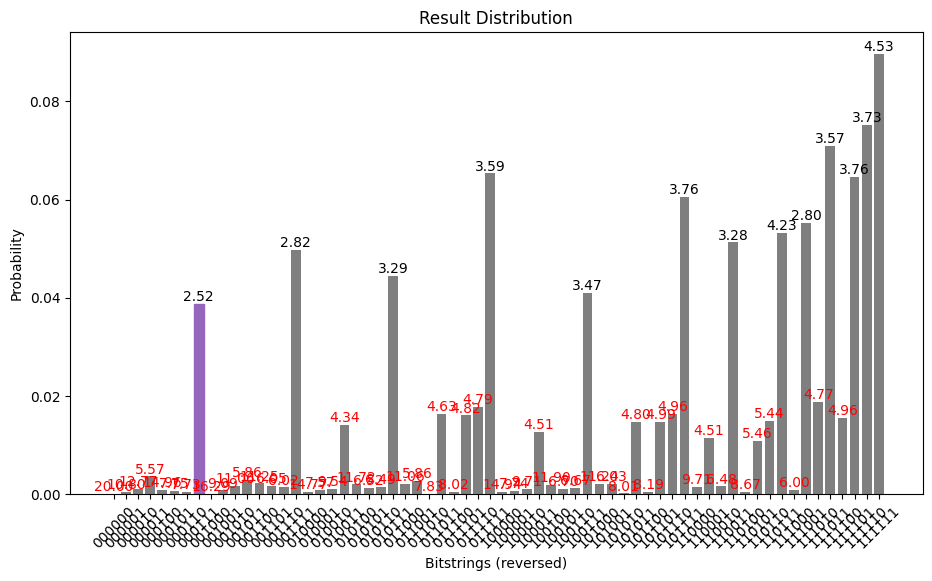

In [5]:
from src.qaoa.models.MaxCutProblem import MaxCutProblem
problem = MaxCutProblem()
graphs = problem.get_erdos_renyi_graphs_paper1()


graph = graphs[0]
quantum2 = QAOArunner(graph=graph, 
                     backend_mode = 'statevector', #statevector, noisy_sampling
                     param_initialization= 'uniform',
                     qaoa_variant='vanilla',    
                     optimizer='COBYLA',
                     depth =1,
                     problem_type='minvertexcover',
                     warm_start=False,
                     amount_shots = 5000,
                     max_tol = 1e-8,#lower shots and tolerance for faster runs
                     lagrangian_multiplier=2
                     )

quantum2.build_circuit()
for i in range(10):
    print(quantum2.get_initial_params())
print(quantum2.cost_hamiltonian)
quantum2.run()
print('Time elapsed:', quantum2.time_elapsed)
print(quantum2.solution)
print(quantum2.hamming_string)
print('quantum', quantum2.evaluate_solution())
print('clsaasic' , quantum2.classical_objective_value)


print(quantum2.fev)
print(quantum2.final_params)
print(quantum2.time_elapsed)
print('m',quantum2.get_prob_measure_optimal())
quantum2.print_bitstrings()

SparsePauliOp(['IIIIIIIZI', 'IIIIIIIIZ', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIZIIIIIZ', 'IIIIZIIZI', 'IZIIIIIZI', 'IIIIIZZII', 'IIIZIIZII', 'ZIIIIIZII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'ZIIZIIIII', 'ZIZIIIIII'],
              coeffs=[1.1422402 +0.j, 1.27205607+0.j, 1.77401134+0.j, 1.2180186 +0.j,
 1.18277482+0.j, 1.26102489+0.j, 1.24965776+0.j, 0.78399397+0.j,
 1.77595477+0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j])
Time elapsed: 0.025615453720092773
[1, 0, 1, 1, 1, 0, 0, 0, 0]
None
quantum 8.106278336454151
clsaasic 2.4224180621178033
20
[3.46345832 1.10323076]
0.025615453720092773
m 0.007646618159417913
final expectation value:  8.770770948534974
9.34026757998167
Expected objective value from distr

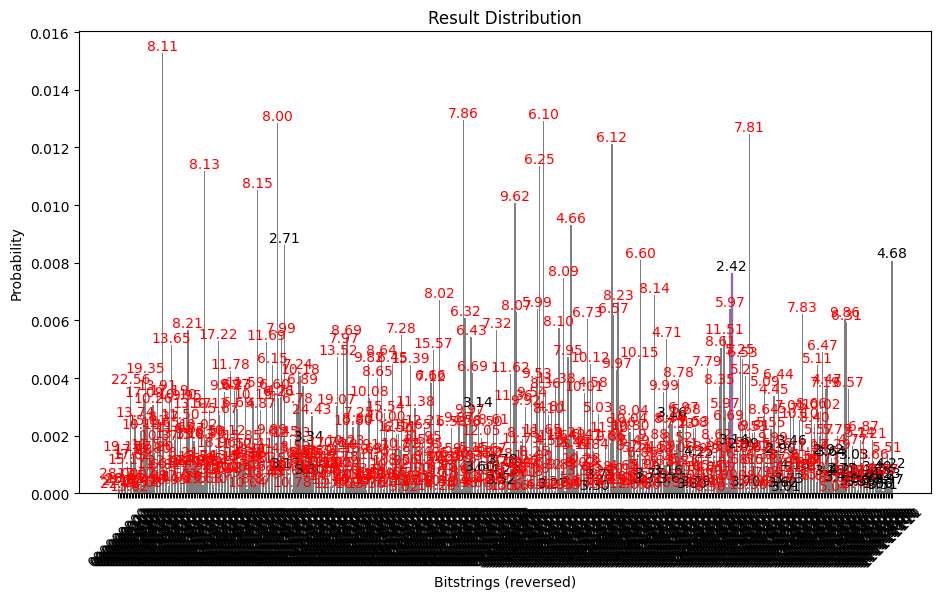

In [7]:
from src.qaoa.models.MaxCutProblem import MaxCutProblem
problem = MaxCutProblem()
graphs = problem.get_erdos_renyi_graphs_paper1()


graph = graphs[3]
quantum = QAOArunner(graph=graph, 
                     backend_mode = 'statevector', #statevector, noisy_sampling
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla',    
                     optimizer='COBYLA',
                     depth =1,
                     problem_type='minvertexcover',
                     warm_start=False,
                     amount_shots = 1000,
                     max_tol = 1e-2,#lower shots and tolerance for faster runs
                     lagrangian_multiplier=2
                     )

quantum.build_circuit()
print(quantum.cost_hamiltonian)
quantum.run()
print('Time elapsed:', quantum.time_elapsed)
print(quantum.solution)
print(quantum.hamming_string)
print('quantum', quantum.evaluate_solution())
print('clsaasic' , quantum.classical_objective_value)


print(quantum.fev)
print(quantum.final_params)
print(quantum.time_elapsed)
print('m',quantum.get_prob_measure_optimal())
print('final expectation value: ',quantum.final_expectation_value)
print(quantum.offset)
quantum.print_bitstrings()

In [ ]:
print(quantum.final_expectation_value)

4.872566198964705


In [ ]:
# Simulate a short run, then
print(f"CPU usage during simulation: {psutil.cpu_percent()}%")

CPU usage during simulation: 13.6%


In [ ]:
print(quantum.circuit.count_ops())


OrderedDict([('rzz', 10), ('h', 6), ('rz', 6), ('rx', 6)])


{'amount_shots': 1000,
 'backend': AerSimulator('aer_simulator_statevector'),
 'backend_mode': 'statevector',
 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000018B666F6530>,
 'classical_objective_func_vals': [],
 'classical_objective_value': 2.5239258519758856,
 'classical_solution': [1.0, 1.0, 1.0, 0, 0, 0],
 'cost_hamiltonian': SparsePauliOp(['IIIIZI', 'IIIIIZ', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IZIZII', 'ZIIZII'],
              coeffs=[1.61496939+0.j, 2.10128806+0.j, 1.02177962+0.j, 0.85263048+0.j,
 1.11605464+0.j, 1.02910093+0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j]),
 'depth': 1,
 'epsilon': 0.3,
 'fev': 591,
 'final_expectation_value': np.float64(3.0399367861962556),
 'final_params': array([3.92680794, 4.64242055, 3.92643802, 3.85504349, 2.3506192

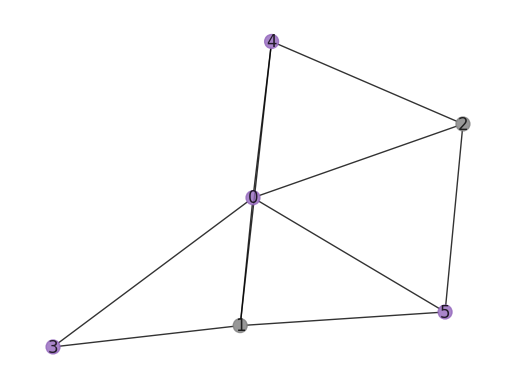

In [ ]:
from pprint import pprint

pprint(quantum.__dict__)
quantum.plot_result()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_ibm_runtime import EstimatorV2 as Estimator
# Define the grid resolution
num_points = 100
gamma_vals = np.linspace(0, 4 * np.pi, num_points)
beta_vals = np.linspace(0,2* np.pi, num_points)
Gamma, Beta = np.meshgrid(gamma_vals, beta_vals)
Z = np.zeros_like(Gamma)



minvertexcover = False

quantum = QAOArunner(graph=graph, 
                     backend_mode='statevector',
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla', 
                     optimizer='COBYLA',
                     warm_start=False,
                     depth = 1,
                     vertexcover=minvertexcover,
                     amount_shots = 1000,
                     max_tol = 1e-8,
                     lagrangian_multiplier=2
                     )
quantum.build_circuit()
estimator = Estimator(mode=quantum.backend)
estimator.options.default_shots = 5000
# Evaluate cost function at each grid point



for i in tqdm(range(Gamma.shape[0]), desc="Evaluating energy landscape"):
    for j in range(Gamma.shape[1]):
        params = np.array([Gamma[i, j], Beta[i, j]])  # Format your params as needed
        Z[i, j] = quantum.cost_func_estimator(params, quantum.circuit, quantum.cost_hamiltonian,estimator)

# Plot the energy landscape
plt.figure(figsize=(8, 6))
cp = plt.contourf(Gamma, Beta, Z, levels=50)
plt.colorbar(cp, label='Energy')
plt.title("Energy Landscape over [γ, β]")
plt.xlabel("Gamma (γ)")
plt.ylabel("Beta (β)")
plt.show()


TypeError: QAOArunner.__init__() got an unexpected keyword argument 'vertexcover'

In [ ]:
import pandas as pd

# Save Z as a CSV file
df_z = pd.DataFrame({'x': Gamma.ravel(), 'y': Beta.ravel(), 'z': Z.ravel()})
df_z.columns = ['x', 'y', 'z']
df_z.to_csv('percentage_measure_optimal_erdos_renyi_5_2_MaxCut.csv', index=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

strin = 'MinVertexCover' if minvertexcover else 'MaxCut'

import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=Gamma, y=Beta, colorscale='Viridis')])
fig.update_layout(
    title=f"Percent chance of sampling optimal solution given [γ, β] for Erdos Renyi graph size 5, high prob of edges, for {strin}",
    scene=dict(
        xaxis_title="Gamma (γ)",
        yaxis_title="Beta (β)",
        zaxis_title="Energy"
    )
)
fig.show()

